# **16. Algoritmo HHL**

# **Dive in Learning**

# ***Diplomado en Computación y Programación Cuántica***

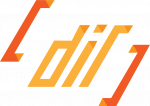

In [ ]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.2 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import numpy as np
import scipy
import functools as ft
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **Introducción**

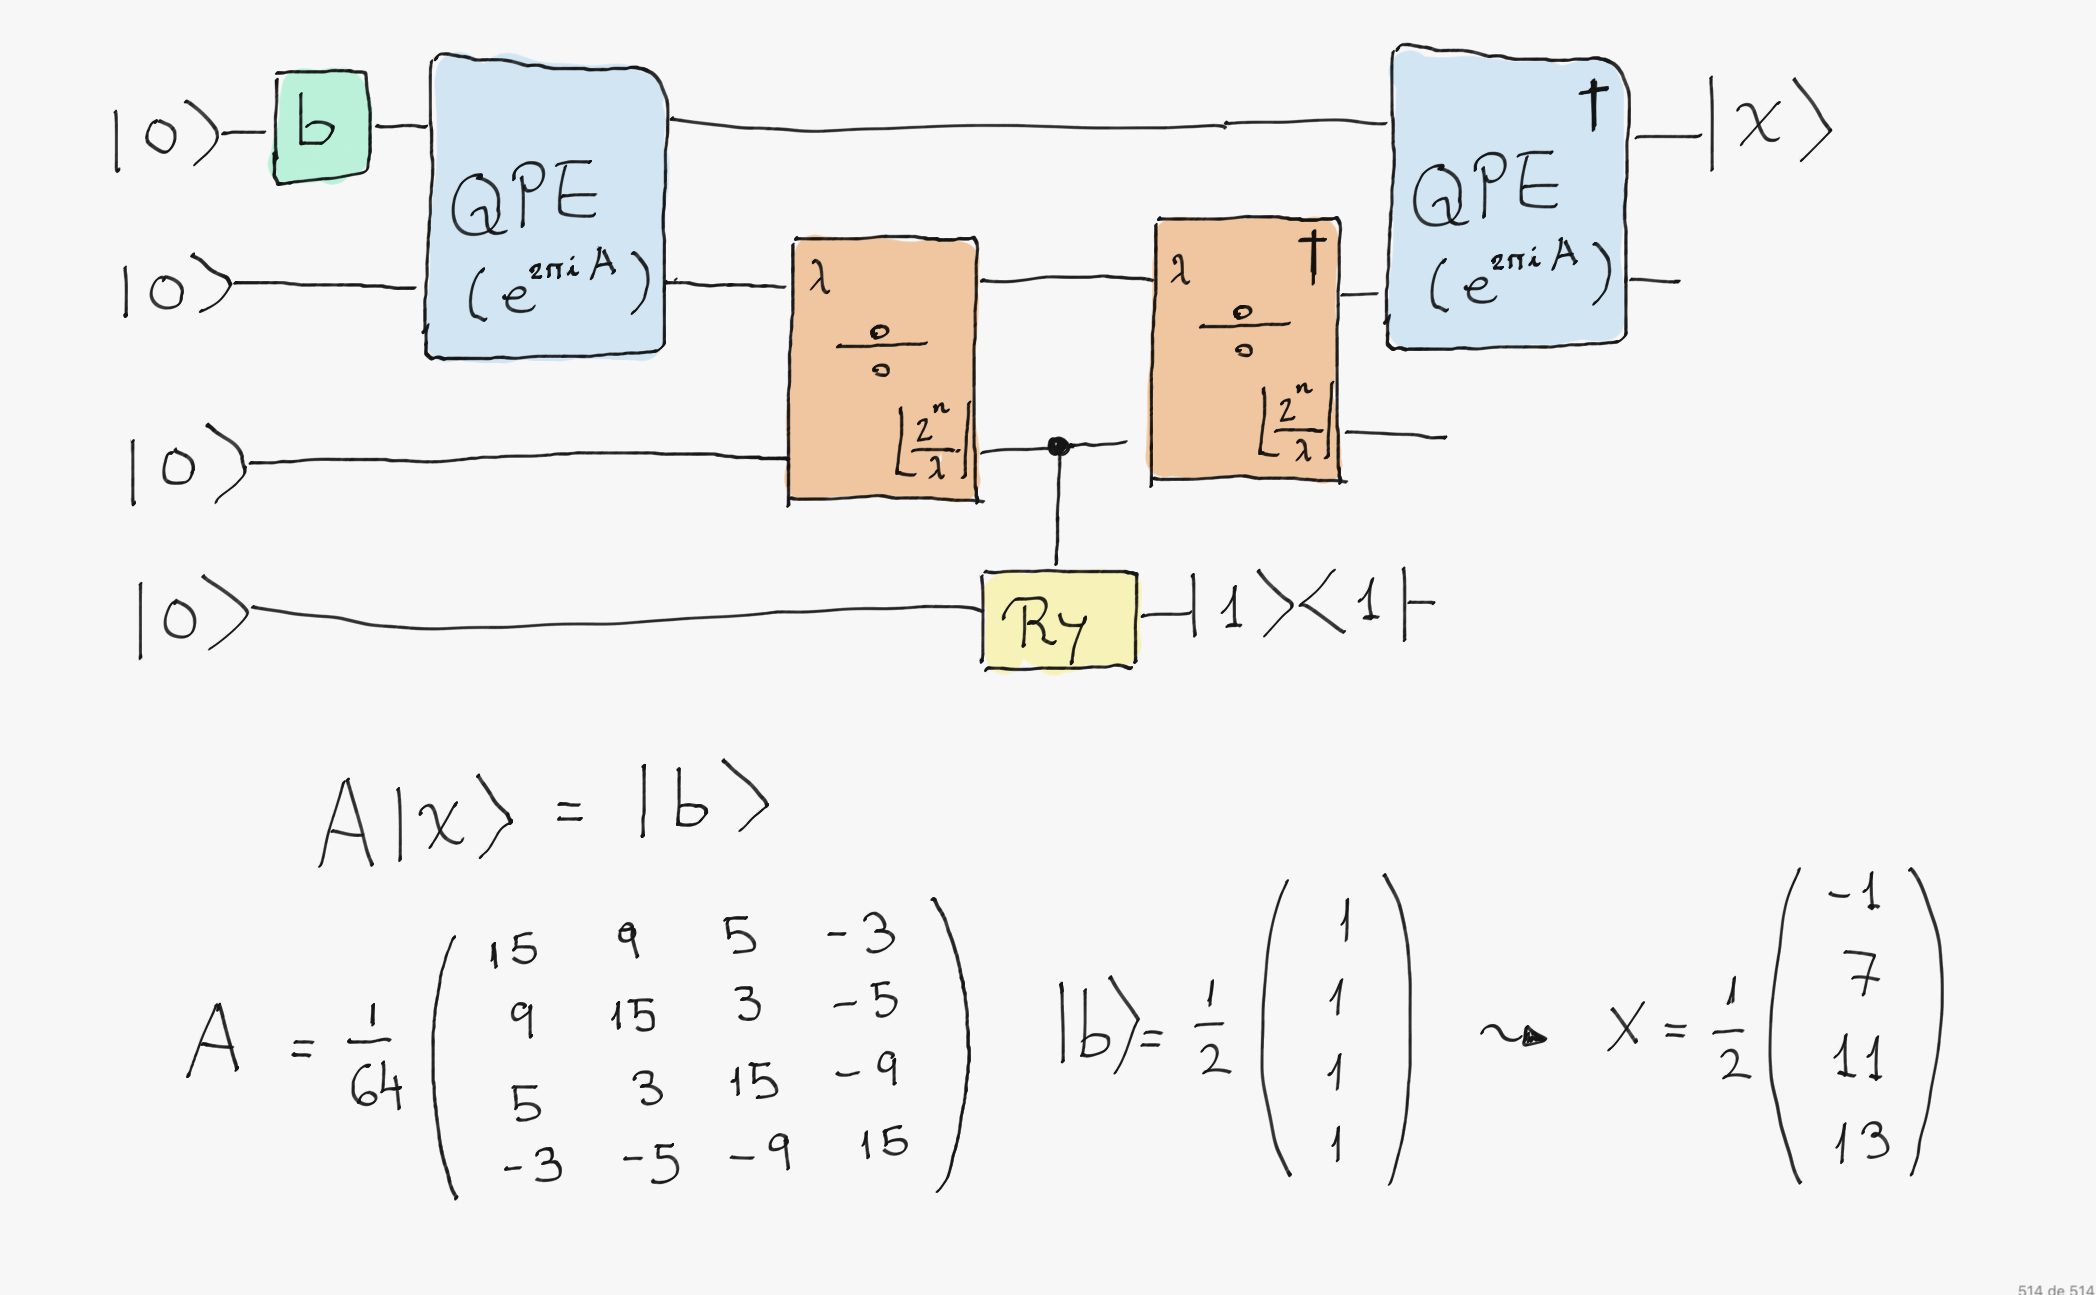

La imagen muestra el **algoritmo HHL** (Harrow-Hassidim-Lloyd) aplicado a un sistema de ecuaciones lineales cuántico. Se trata de resolver el problema:

$$A\vert x\rangle =\vert b\rangle,$$

donde

* $\vert b⟩$ es un estado inicial dado por

$$\vert b\rangle =\frac{1}{2}\begin{pmatrix}1\\ 1\\ 1\\ 1\end{pmatrix},$$
* y $\vert x\rangle$ es el vector solución que buscamos.


$$A=\sum_{i}\lambda_{i}\vert v_{i}\rangle\langle v_{i}\vert$$

$$\vert b\rangle =\sum_{i}b_{i}\vert v_{i}\rangle$$

$$A^{-1}=\sum_{i}\frac{1}{\lambda_{i}}\vert v_{i}\rangle\langle v_{i}\vert$$

$$\vert x\rangle =A^{-1}\vert b\rangle$$

$$\vert x\rangle =\sum_{i}\frac{b_{i}}{\lambda_{i}}\vert v_{i}\rangle$$

$\textbf{1. Preparación del estado $\vert b⟩$}$

El sistema parte de un estado inicial en los registros de qubits, que representa $\vert b⟩$.

$$\vert b\rangle =\sum_{i}b_{i}\vert v_{i}\rangle$$

$\textbf{2. Estimación de fase cuántica (QPE - Quantum Phase Estimation)}$

La primera **caja azul** en la imagen es la estimación de fase cuántica (QPE).

$$\vert b\rangle =\sum_{i}b_{i}\vert v_{i}\rangle\vert 0\rangle$$

$$QPE\vert b\rangle =e^{2\pi iA}\vert b\rangle$$

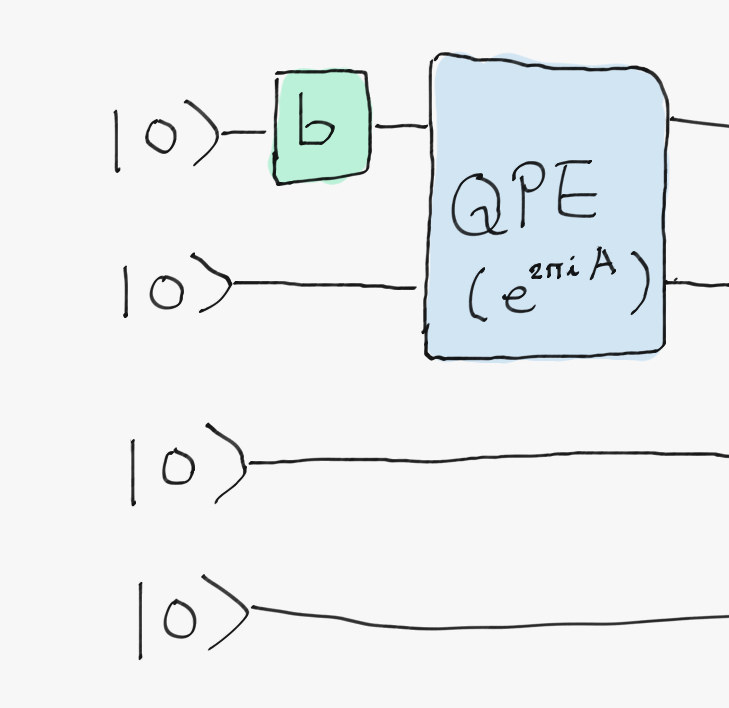

Se aplica la transformación unitaria $e^{2\pi iA}$ a los qubits de entrada.

Esta operación permite encontrar los valores propios $\lambda$ de $A$, que se codifican en los registros auxiliares.

$\textbf{3. Inversión de los valores propios $\lambda$ (División cuántica)}$

El problema de resolver $A\vert x⟩=\vert b⟩$ equivale a aplicar la inversa de $A$:

$$\vert x\rangle =A^{-1}\vert b\rangle$$

* Como $A$ es hermitiana, tiene valores propios $\lambda$, y vectores propios $\vert v⟩$.

* Para invertir $A$, necesitamos dividir por $\lambda$, lo que se hace con la rotación controlada $RY$ en la imagen.

* El **operador naranja** con $\lambda^{-1}$ representa este paso, aplicando la transformación:

$$\frac{1}{\lambda}\vert b\rangle$$

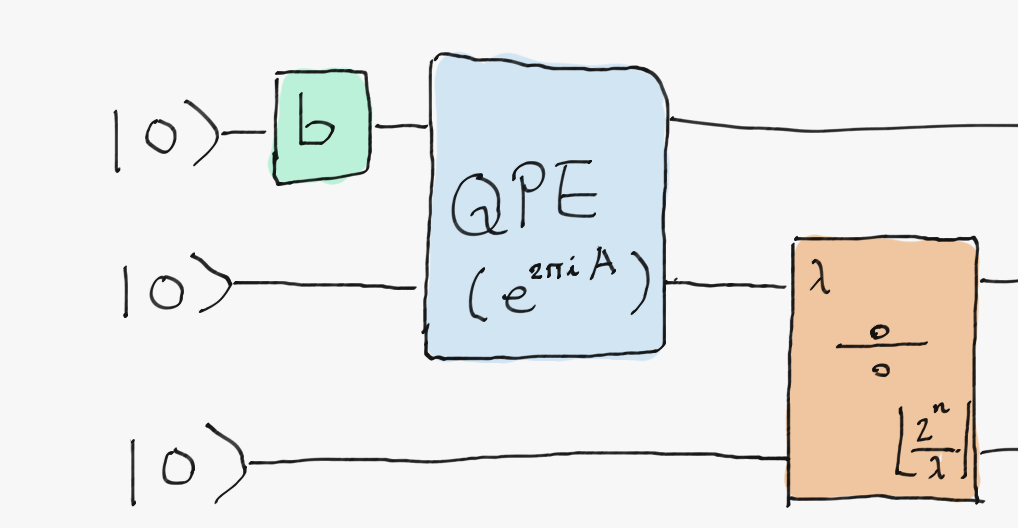

$\textbf{4. Deshacer la estimación de fase (QPE$^{\dagger}$)}$

Después de la división cuántica, aplicamos la transformada inversa de QPE (**caja azul derecha**) para deshacer la transformación en el registro auxiliar.

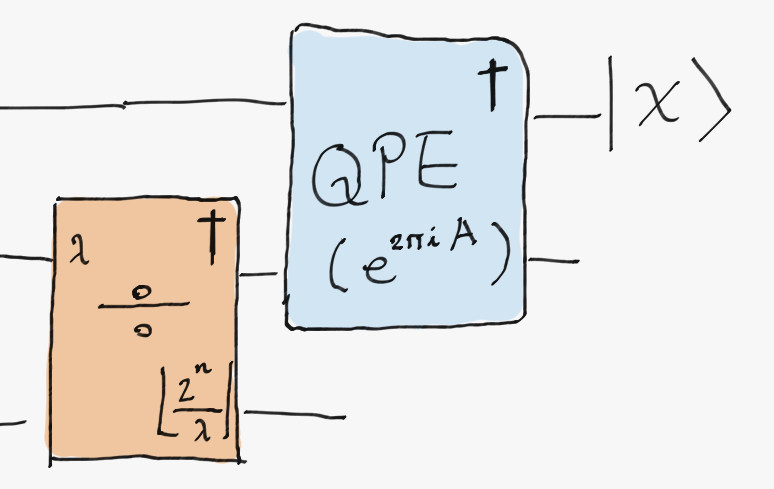

$\textbf{5. Medición del registro auxiliar (Postselección)}$

Después de ejecutar el algoritmo, la solución que obtenemos es:

$$\vert x\rangle =\frac{1}{2}\begin{pmatrix}-1\\ 7\\ 11\\ 13\end{pmatrix}$$

Esta es la representación del vector solución del sistema $A\vert x⟩=\vert b⟩$.

# **Implementación en PennyLane**

A continuación implementaremos primero la **división cuántica** usando técnicas de aritmética cuántica y la Transformada Cuántica de Fourier (**QFT**). Esta es una parte fundamental del **algoritmo HHL**, ya que necesitamos calcular $\frac{1}{\lambda}$ en la etapa de inversión de autovalores.

In [ ]:
# Esta celda es el conjunto de operaciones necesarias para implementar la división

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

def substract_m_n(wires_m, wires_n):
    # |m>|n> ->  |m - n> |n>

    qml.QFT(wires = wires_m)


    for i in range(len(wires_n)):
        qml.ctrl(add_k_fourier, control=wires_n[i])(-2 **(len(wires_n) - i - 1), wires_m)

    qml.adjoint(qml.QFT)(wires = wires_m)

def is_greater(wires_m, wires_n, wires_aux, wires_target):

    wires_m_aux = [wires_aux] + list(wires_m)
    substract_m_n(wires_m_aux, wires_n)

    qml.PauliX(wires = wires_aux)
    qml.CNOT(wires = [wires_aux, wires_target])
    qml.PauliX(wires = wires_aux)

    qml.adjoint(substract_m_n)(wires_m_aux, wires_n)


def division(wires_dividendo, wires_divisor, wires_aux_dividendo, wires_solucion, wires_aux):

    wires_dividendo_totales = wires_aux_dividendo + wires_dividendo

    for i in range(len(wires_solucion)):
        window = wires_dividendo_totales[i - 1: len(wires_divisor)+ i]
        if i == 0:
            window = wires_dividendo_totales[0: len(wires_divisor)]

        is_greater(window, wires_divisor, wires_aux, wires_solucion[i])
        qml.ctrl(substract_m_n, control = wires_solucion[i])(window, wires_divisor)

`add_k_fourier(k, wires)`: Esta función aplica una rotación de fase controlada en la base de Fourier para agregar un número $k$ en el registro cuántico.

* Se aplican **rotaciones** $RZ$ con ángulos que dependen de $k$ y la posición del qubit en el registro.

* Se usa para manipular números en la representación de QFT.

📌 **Propósito:** *Modificar los estados en la base de Fourier.*

`substract_m_n(wires_m, wires_n)`: Esta función resta dos registros cuánticos $\vert m⟩$ y $\vert n⟩$ de la siguiente manera:

1. Aplicar la QFT a $\vert m⟩$.

2. Controlar rotaciones en función de $\vert n⟩$, implementando $\vert m−n⟩$.

3. Aplicar la QFT inversa para volver a la base computacional.

📌 **Propósito:** *Implementar la operación $\vert m⟩→\vert m−n⟩$, crucial en la división.*

`is_greater(wires_m, wires_n, wires_aux, wires_target)`: Esta función compara dos números cuánticos $m$ y $n$ y almacena si $m>n$ en un qubit auxiliar.

1. Resta $m−n$.

2. Si el resultado es positivo, **activa el qubit auxiliar**.

3. Restaura $\vert m⟩$ y $\vert n⟩$ a su estado original.

📌 **Propósito:** *Determinar si $m>n$ de forma cuántica.*

`division(wires_dividendo, wires_divisor, wires_aux_dividendo, wires_solucion, wires_aux)`: Esta es la función principal que implementa la división cuántica paso a paso:

1. **Itera sobre los bits de la solución.**

2. En cada iteración:

* Define una ventana de bits del dividendo.

* Comprueba si la parte seleccionada es **mayor que el divisor**.

* Si lo es, **resta el divisor** y marca un "$1$" en la solución.

📌 **Propósito:** *Realizar la operación división cuántica.*

$\textbf{Relación con HHL}$

Este código implementa la **operación** $\lambda^{-1}$ **del algoritmo HHL:**

* Dado que los valores propios $\lambda$ se obtienen en **QPE**, necesitamos invertirlos para resolver $A^{-1}b$.

* Como la división cuántica no es trivial, **se usa QFT y operaciones** aritméticas.

💡 **Este fragmento de código es clave para calcular $1/\lambda$ en el paso de inversión del algoritmo HHL.**

$\textbf{Recapitulación}$

Estamos resolviendo la ecuación

$$\textbf{$A\vert b\rangle =\vert x\rangle$}$$

donde

* $A$ es una matris $4\times 4$.

* $\vert b\rangle$ es el estado inicial.

**Y el objetivo en obtener $\vert x\rangle$, la solución del sistema.**

In [ ]:
# Subrutina del HHL

A = 1/64 * np.array([[15, 9, 5, -3],
                       [9, 15, 3, -5],
                       [5, 3, 15, -9],
                       [-3, -5, -9, 15]])

U = scipy.linalg.expm(2 * np.pi * 1j * A)

# Construye el ciruito
dev = qml.device("lightning.qubit", wires=21)

wires_b = [0,1]
wires_divisor = [2,3,4,5]
wires_solucion = [11,12,13,14,15]
wires_dividendo = [6,7,8,9,10]
wires_aux_window = [16,17,18]
aux_div = 19
wire_rotacion = 20

def qpe_division():
    qml.QuantumPhaseEstimation(U, wires_b, wires_divisor)
    qml.PauliX(wires = wires_dividendo[0])
    division(wires_dividendo, wires_divisor, wires_aux_window, wires_solucion, aux_div)

@qml.qnode(dev)
def circuit():

    #inicializamos b
    qml.Hadamard(wires = 0)
    qml.Hadamard(wires = 1)

    qpe_division()

    for i in range(len(wires_solucion)):

        C = 1/2 ** (len(wires_solucion)- 1)
        qml.CRY(2 *np.arccos(2 ** (len(wires_solucion)-i-1) * C), wires = [wires_solucion[i], wire_rotacion])

    qml.PauliX(wires = wire_rotacion)

    qml.adjoint(qpe_division)()

    return qml.density_matrix(wires = wires_b +  [wire_rotacion])

In [ ]:
def qubit_postselect_dm(meas_outputs, wires, in_state):

    num_wires = int(np.log2(len(in_state)))
    arr = [np.identity(2) for _ in range(num_wires)]
    for i in range(len(wires)):
        if meas_outputs[i]=='0':
            arr[int(wires[i])]=np.array([1,0])
        elif meas_outputs[i]=='1':
            arr[int(wires[i])]=np.array([0,1])

    projector = ft.reduce(np.kron,arr)
    out_state = np.linalg.multi_dot([projector, in_state, projector.T])
    out_state = out_state/np.trace(out_state)

    return [out_state[i][i] for i in range(len(out_state))]

Los pasos que el código ejecuta son:

**1. Quantum Phase Estimation (QPE)**

* Codifica los valores de $A$.

* En el código: `qml.QuantumPhaseEstimation(U, wires_b, wires_divisor)`.

**2. División cuántica**

* Implementa la operación $\lambda^{-1}$, que en la imagen aparece como una compuerta controlada en **color naranja**.

* En el código: `division(wires_dividendo, wires_divisor, wires_aux_window, wires_solucion, aux_div)`.

**3. Rotación controlada $RY$**

* Convierte los valores propios en los coeficientes correctos para la solución $\vert x\rangle$.

* En el código:

`for i in range(len(wires_solucion)):
    C = 1/2 ** (len(wires_solucion)- 1)
    qml.CRY(2 *np.arccos(2 ** (len(wires_solucion)-i-1) * C), wires = [wires_solucion[i], wire_rotacion])`

**4. Finalmente, el circuito se deshace del procesamiento cuántico de fase con `qml.adjoint(qpe_division)()` para regresar la solución en el estado**

## **Solución cuántica**

In [ ]:
# Dibujo simple
print(qml.draw_mpl(circuit)())

(<Figure size 75600x2200 with 1 Axes>, <Axes: >)


In [ ]:
dm = circuit()
output = np.real(qubit_postselect_dm("1", [2], dm))
print(output)

[0.00294118 0.14411765 0.35588235 0.49705882]


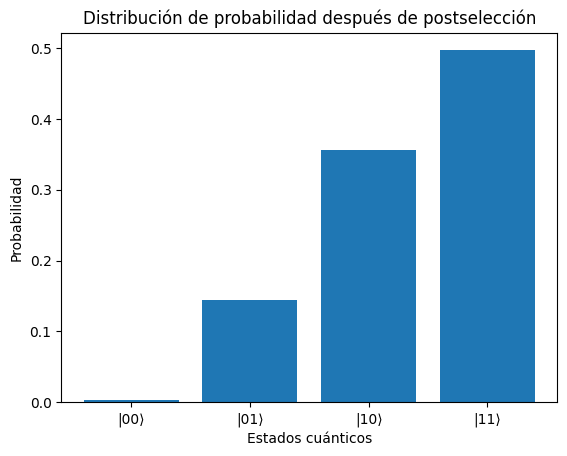

In [ ]:
# plt.bar(range(len(output)), output)

plt.bar(["|00⟩", "|01⟩", "|10⟩", "|11⟩"], output)
plt.xlabel("Estados cuánticos")
plt.ylabel("Probabilidad")
plt.title("Distribución de probabilidad después de postselección")
plt.show()

## **Solución clásica**

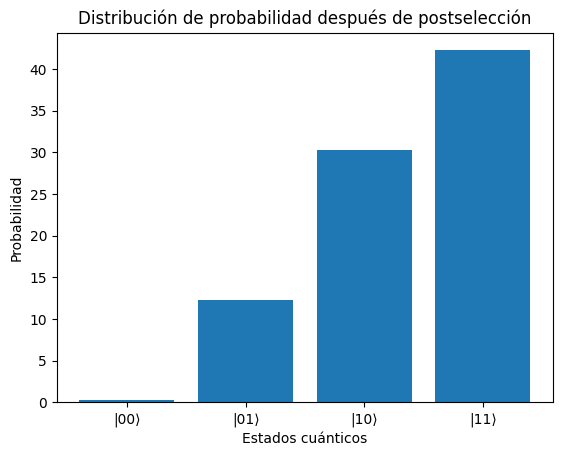

In [ ]:
solucion = (1/2 * np.array([-1, 7, 11, 13])) ** 2


plt.bar(["|00⟩", "|01⟩", "|10⟩", "|11⟩"], solucion)
plt.xlabel("Estados cuánticos")
plt.ylabel("Probabilidad")
plt.title("Distribución de probabilidad después de postselección")
plt.show()

## **Solución clásica vs. cuántica**

In [ ]:
# Definimos la matriz A
A = 1/64 * np.array([[15, 9, 5, -3],
                       [9, 15, 3, -5],
                       [5, 3, 15, -9],
                       [-3, -5, -9, 15]])

# Vector b = estado |b⟩ = (1/2)[1, 1, 1, 1]
b = 1/2 * np.ones(4)

# Resolver el sistema A x = b
x = np.linalg.solve(A, b)

# Normalizamos para obtener el estado |x⟩ cuántico
x_normalized = x / np.linalg.norm(x)

# Mostramos la solución
print("Solución exacta (x):")
print(x)

print("\nEstado normalizado (x) clásico:")
print(x_normalized)

print("\nDistribución de probabilidad asociada a |x⟩:")
print(np.abs(x_normalized)**2)


Solución exacta (x):
[-0.5  3.5  5.5  6.5]

Estado normalizado (x) clásico:
[-0.05423261  0.3796283   0.59655876  0.70502399]

Distribución de probabilidad asociada a |x⟩:
[0.00294118 0.14411765 0.35588235 0.49705882]


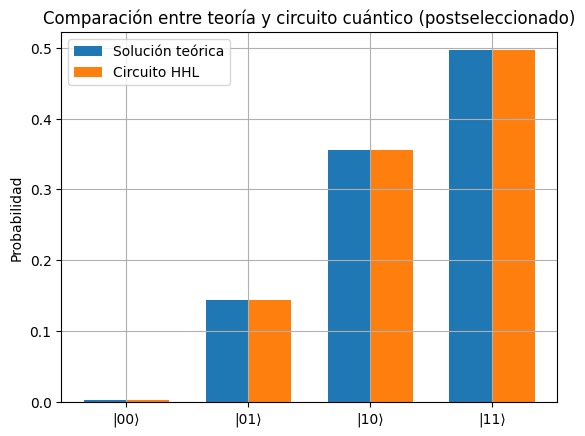

In [ ]:
# Solución teórica clásica (normalizada)
x = 1/2 * np.array([-1, 7, 11, 13])
x_normalized = x / np.linalg.norm(x)
sol_teorica = x_normalized**2

# Salida cuántica del circuito (ya la obtuviste con `qubit_postselect_dm`)
salida_circuito = output  # <- Asegúrate de que esta variable ya exista

labels = ["|00⟩", "|01⟩", "|10⟩", "|11⟩"]

x_pos = np.arange(len(labels))
width = 0.35

plt.bar(x_pos - width/2, sol_teorica, width, label='Solución teórica')
plt.bar(x_pos + width/2, salida_circuito, width, label='Circuito HHL')

plt.xticks(x_pos, labels)
plt.ylabel("Probabilidad")
plt.title("Comparación entre teoría y circuito cuántico (postseleccionado)")
plt.legend()
plt.grid(True)
plt.show()
